# CNN Image Classification Model with Transfer Learning

In [1]:
# import packages
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# load cifar-100 dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar100.load_data()

169017344/169001437 [==============================] - 3s 0us/step


In [3]:
# check data shape
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
# check number of y labels
print("Number of labels:", len(np.unique(y_train)))

Number of labels: 100


In [5]:
# CIFAR100 fine label names from https://towardsdatascience.com/cifar-100-pre-processing-for-image-recognition-task-68015b43d658
label_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

There are 50K train images and 10K test images. There are a total of 100 labels.

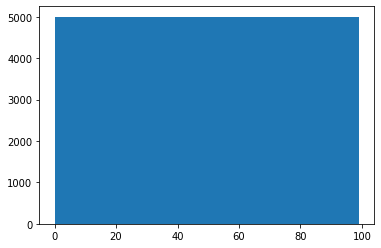

In [6]:
# distribution of classes
plt.hist(y_train);

For each y label, there are 5000 image examples in the training dataset. In other words, the classes are balanced.

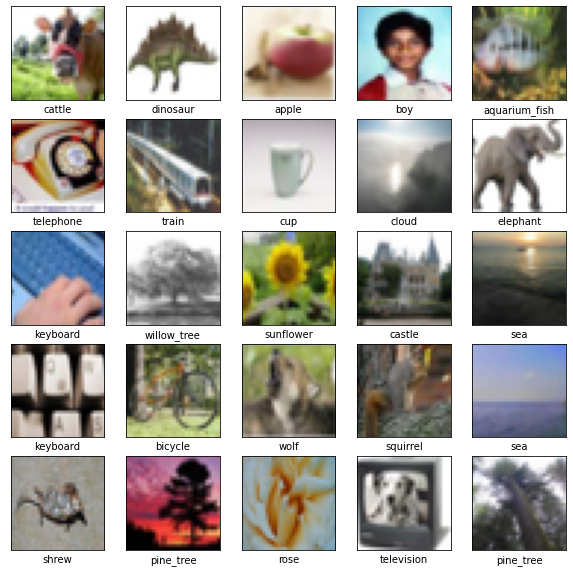

In [7]:
# show an example of how our dataset looks like
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(label_names[y_train[i][0]])
plt.show()

## Data Preprocessing

In [8]:
# convert y integer label to one-hot encoded matrix
y_train = tf.keras.utils.to_categorical(y_train, num_classes=100)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=100)

## Build and Train a model

In [9]:
# load resnet model for transfer learning
resnet_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
resnet_model.trainable = False

94781440/94765736 [==============================] - 0s 0us/step


In [10]:
# set up model architecture
inputs = tf.keras.Input(shape=(32, 32, 3))
x = tf.keras.applications.resnet50.preprocess_input(inputs) # pre-process inputs as required by ResNet50 model
x = resnet_model(inputs, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(100, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 100)               102500    
                                                                 
Total params: 25,788,388
Trainable params: 2,200,676
Non-trai

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
checkpoint_path = 'checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss',
                             verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

In [14]:
num_epochs = 100

history = model.fit(X_train, y_train,
                    epochs=num_epochs,
                    callbacks=[checkpoint, early_stopping],
                    validation_data=(X_test, y_test))

Epoch 1/100
1563/1563 [==============================] - ETA: 0s - loss: 3.6426 - accuracy: 0.2002
Epoch 00001: val_loss improved from inf to 2.85938, saving model to checkpoint.ckpt
1563/1563 [==============================] - 47s 24ms/step - loss: 3.6426 - accuracy: 0.2002 - val_loss: 2.8594 - val_accuracy: 0.2967
Epoch 2/100
1562/1563 [============================>.] - ETA: 0s - loss: 2.7434 - accuracy: 0.3196
Epoch 00002: val_loss improved from 2.85938 to 2.66674, saving model to checkpoint.ckpt
1563/1563 [==============================] - 29s 19ms/step - loss: 2.7432 - accuracy: 0.3197 - val_loss: 2.6667 - val_accuracy: 0.3360
Epoch 3/100
1560/1563 [============================>.] - ETA: 0s - loss: 2.4389 - accuracy: 0.3769
Epoch 00003: val_loss improved from 2.66674 to 2.56383, saving model to checkpoint.ckpt
1563/1563 [==============================] - 29s 19ms/step - loss: 2.4388 - accuracy: 0.3770 - val_loss: 2.5638 - val_accuracy: 0.3538
Epoch 4/100
1560/1563 [===============

In [15]:
model.load_weights(checkpoint_path) # load saved best weights
model.save("cifar100-cnn-model.h5") # save current model

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


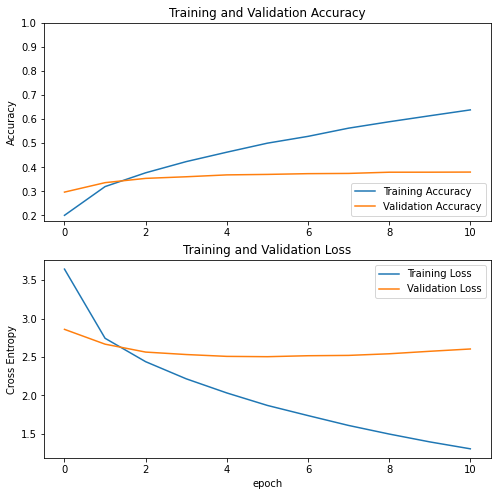

In [18]:
# check model loss and accuracy over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

313/313 - 4s - loss: 2.5039 - accuracy: 0.3703 - 4s/epoch - 14ms/step


Predicted: whale


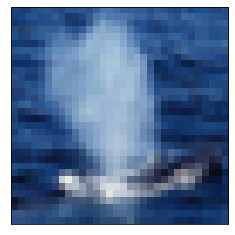

In [55]:
# use the trained model to make predictions!
i = np.random.randint(10000)
example_image = np.expand_dims(X_test[i], axis=0) # match the input image shape
predictions = model.predict(example_image)

# visualize result
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.imshow(X_test[i])
print("Predicted:", label_names[np.argmax(predictions)])

## References
- transfer learning: https://www.tensorflow.org/tutorials/images/transfer_learning
- CNN tutorial: https://www.tensorflow.org/tutorials/images/cnn